In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import time
import progressbar
plt.style.use('dark_background')
%matplotlib inline

import Models as models

import importlib


In [2]:
# Hyper Parameters
EPOCH = 150
BATCH_SIZE = 128
cudaopt = True

# training parameters
LR = 0.005
WD = 0
MN = .9
step_size_schd = 50
gamma_schd = .2
Unfoldings = 6

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = Data.DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle = True) #sampler=Data.sampler.SubsetRandomSampler(train_indices))
test_loader = Data.DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=True)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [3]:
import pdb

def train_model(model,train_loader,test_loader,optimizer,scheduler,EPOCH):

    t0 = time.perf_counter()
    tprev = t0

    Loss_train = np.zeros((EPOCH,))
    Loss_test = np.zeros((EPOCH,))
    Acc_test = np.zeros((EPOCH,))
    Acc_train = np.zeros((EPOCH,))
    Time_test = np.zeros((EPOCH,))

    bar = progressbar.ProgressBar(max_value=EPOCH-1)
    for epoch in range(EPOCH):
        
        scheduler.step()
        bar.update((epoch))
        
        # train 1 epoch
        model.train()
        correct = 0
        train_loss = 0
        rec_error = 0
        for step, (x, y) in enumerate(train_loader):
            b_x = Variable(x)   # batch x, 
            b_y = Variable(y)               # batch label
            if cudaopt:
                b_y, b_x = b_y.cuda(), b_x.cuda()
            scores = model(b_x)
            loss = F.nll_loss(scores, b_y)      # negative log likelyhood
            optimizer.zero_grad()               # clear gradients for this training step
            loss.backward()                     # backpropagation, compute gradients
            optimizer.step()                    # apply gradients
            model.zero_grad()
            
            # computing training accuracy
            pred = scores.data.max(1, keepdim=True)[1]
            correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
            train_loss += F.nll_loss(scores, b_y, reduction='sum').data.item()
            

        Acc_train[epoch] =  100 * float(correct) / float(len(train_loader.dataset))
        Loss_train[epoch] = train_loss / len(train_loader.dataset)

        # testing
        model.eval()
        correct = 0
        test_loss = 0
        NNZ = 0.0
        for step, (x, y) in enumerate(test_loader):
            b_x = Variable(x)   
            b_y = Variable(y)               # batch label
            if cudaopt:
                b_y, b_x = b_y.cuda(), b_x.cuda()
            scores = model(b_x)
            #pdb.set_trace()
            test_loss += F.nll_loss(scores, b_y, reduction='sum').data.item()
            pred = scores.data.max(1, keepdim=True)[1]
            correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()


        Loss_test[epoch] = test_loss/len(test_loader.dataset)
        Acc_test[epoch] =  100 *  float(correct) /float(len(test_loader.dataset))
        Time_test[epoch] = time.perf_counter()-t0
        
        #print('Epoch: ', epoch, '| train loss: ', train_loss.data.cpu().numpy()/len(train_loader.dataset),'| train acc: ', Acc_train[epoch], '%','| test acc: ', Acc_test[epoch], '%')
    
    return model,Acc_train,Acc_test


### Baseline CNN

In [18]:

model_0 = models.ML_ISTA(0)
optimizer = torch.optim.SGD(model_0.parameters(), lr = LR,momentum=MN, weight_decay=WD)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step_size_schd,gamma=gamma_schd)
    

model_0,Acc_train_0,Acc_test_0 = train_model(model_0.cuda(),train_loader,test_loader,optimizer,scheduler,EPOCH)

100% (149 of 149) |######################| Elapsed Time: 0:42:57 ETA:  00:00:00

### ML - ISTA

In [19]:
    
model_mlista = models.ML_ISTA(Unfoldings)
optimizer = torch.optim.SGD(model_mlista.parameters(), lr = LR,momentum=MN, weight_decay=WD)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step_size_schd,gamma=gamma_schd)

model_mlista,Acc_train_mlista,Acc_test_mlista = train_model(model_mlista.cuda(),train_loader,test_loader,optimizer,scheduler,EPOCH)


100% (149 of 149) |######################| Elapsed Time: 1:11:50 ETA:  00:00:00

### ML-FISTA

In [20]:
    
model_mlfista = models.ML_FISTA(Unfoldings)
optimizer = torch.optim.SGD(model_mlfista.parameters(), lr = LR,momentum=MN, weight_decay=WD)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step_size_schd,gamma=gamma_schd)

model_mlfista,Acc_train_mlfista,Acc_test_mlfista = train_model(model_mlfista.cuda(),train_loader,test_loader,optimizer,scheduler,EPOCH)


100% (149 of 149) |######################| Elapsed Time: 1:12:06 ETA:  00:00:00

### Layered BP

In [21]:
    
model_lbp = models.LBP_NET(Unfoldings)
optimizer = torch.optim.SGD(model_lbp.parameters(), lr = LR,momentum=MN, weight_decay=WD)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step_size_schd,gamma=gamma_schd)

model_lbp,Acc_train_lbp,Acc_test_lbp = train_model(model_lbp.cuda(),train_loader,test_loader,optimizer,scheduler,EPOCH)


100% (149 of 149) |######################| Elapsed Time: 1:05:19 ETA:  00:00:00

### ML - LISTA

In [22]:
    
model_mllista = models.ML_LISTA_NET(Unfoldings)
optimizer = torch.optim.SGD(model_mllista.parameters(), lr = LR,momentum=MN, weight_decay=WD)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step_size_schd,gamma=gamma_schd)

model_mllista,Acc_train_mllista,Acc_test_mllista = train_model(model_mllista.cuda(),train_loader,test_loader,optimizer,scheduler,EPOCH)


100% (149 of 149) |######################| Elapsed Time: 1:17:34 ETA:  00:00:00

### ML - LISTA 2

In [23]:
importlib.reload(models)

model_mllista_b = models.ML_LISTA_NET_b(Unfoldings)
optimizer = torch.optim.SGD(model_mllista_b.parameters(), lr = LR,momentum=MN, weight_decay=WD)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step_size_schd,gamma=gamma_schd)

model_mllista_b,Acc_train_mllista_b,Acc_test_mllista_b = train_model(model_mllista_b.cuda(),train_loader,test_loader,optimizer,scheduler,EPOCH)


100% (149 of 149) |######################| Elapsed Time: 1:17:36 ETA:  00:00:00

### All Free

In [24]:
importlib.reload(models)
    
model_allfree = models.All_Free()
optimizer = torch.optim.SGD(model_allfree.parameters(), lr = LR,momentum=MN, weight_decay=WD)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step_size_schd,gamma=gamma_schd)

model_allfree,Acc_train_allfree,Acc_test_allfree = train_model(model_allfree.cuda(),train_loader,test_loader,optimizer,scheduler,EPOCH)


100% (149 of 149) |######################| Elapsed Time: 1:04:19 ETA:  00:00:00

### Results

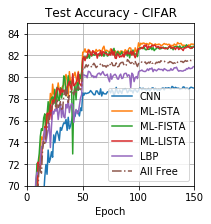

In [26]:
plt.figure(figsize=(3,3))
plt.style.use('default')
plt.plot(Acc_test_0,label= 'CNN')
plt.plot(Acc_test_mlista,label= 'ML-ISTA')
plt.plot(Acc_test_mlfista,label= 'ML-FISTA')
plt.plot(Acc_test_mllista,label= 'ML-LISTA')
plt.plot(Acc_test_lbp,label= 'LBP')
plt.plot(Acc_test_allfree,'-.',label= 'All Free')
#plt.plot(Acc_test_allfree_t,'-.',label= 'All Free Tight')
plt.title('Test Accuracy - CIFAR10
plt.grid()
plt.xlabel('Epoch')
plt.axis([0,EPOCH,70,85])
plt.legend()
plt.savefig("CIFAR_results.pdf", bbox_inches='tight')

In [27]:
print('Baseline: ', np.mean(Acc_test_0[-10:-1]), '. ML-ISTA: ', np.mean(Acc_test_mlista[-10:-1]), '. ML-FISTA: ', np.mean(Acc_test_mlfista[-10:-1]),'ML-LISTA: ', np.mean(Acc_test_mllista[-10:-1]) ,'. Layered BP: ', np.mean(Acc_test_lbp[-10:-1]),'. All Free', np.mean(Acc_test_allfree[-10:-1]) ) 

Baseline:  79.0011111111111 . ML-ISTA:  82.92555555555555 . ML-FISTA:  82.78999999999999 ML-LISTA:  82.68333333333334 . Layered BP:  80.73333333333332 . All Free 81.48333333333333
